# Python Lab Group 10
## Mohamamad Rafi Shaik
## Rajaragunanthan Palanisamy

In [ ]:
## Linear Regression

In [2]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from random import sample

In [4]:
#from google.colab import files
#file = files.upload()  #upload file into google colab session

housing_df= pd.read_csv('housing.csv', header=None)

concrete_df= pd.read_csv('concreteData.csv', header=None)

yatch_df= pd.read_csv('yachtData.csv', header=None)

In [5]:
housing_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
concrete_df.head()

In [ ]:
yatch_df.head()

## Steps implemented
1. Added regularization term using Norm 2
  Normal equation (Closed form solution) 
Gradient Descent. 
Passed the regularization as a parameter to your class, so you could run your model with regularization term or without regularization term 
2. Added a function to calculate the Stochastic gradient descent.
Be sure to pass the necessary parameters to your class so you could switch between gradient descent or stochastic gradient descent.
Added a plotting function that will plot the error costs of the gradient descent.
Be sure to plot the cost of your model during the training steps. 
3. Reported the RMSE and SSE over the test set for all three datasets. 

4. Provided our observations on hyper parameters like learning rate and regularization parameters on the learning.

In [6]:

class LinearRegression:
    def __init__(self,
                 X,
                 y, learningRate,
                 tolerance,
                 maxIteration,
                 gd=False,
                 stochastic=False,
                 reg=False,
                 batch_size=100,
                 alpha=1.0) -> None:
        self.X = X
        self.y = y
        self.tolerance = tolerance
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.gd = gd
        self.stochastic = stochastic
        self.reg = reg
        self.batch_size = batch_size
        self.alpha = alpha
        self.errors = []

    def splitTrainTest(self):
        """Splits the data into X_train, X_test, y_train, y_test"""
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y,
                                                            test_size=0.3,
                                                            random_state=1)
        return (X_train, X_test, y_train, y_test)

    def add_X0(self, X):
        """Add new column at begining with all 1's for the intercept weight"""
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize(self, X):
        """Z-Square standardization"""
        mean = np.mean(X, 0)
        std = np.std(X, 0)
        X_norm = (X - mean) / std
        X_norm = self.add_X0(X_norm)
        return X_norm, mean, std

    def normalizetestdata(self, X, meanTrain, stdTrain):
        """Normalize test data using parameters from training dataset"""
        X_norm =  (X - meanTrain) / stdTrain
        X_norm = self.add_X0(X_norm)
        return X_norm

    def l2_regularization(self, w):
        """Calculate regularization term."""
        return self.alpha * 0.5 * np.linalg.norm(w, 2)

    def grad_reg_term(self, w):
        """Gradient penalty term"""
        gradient_penalty = np.asarray(self.alpha) * w
        # Insert 0 for bias term.
        return np.insert(gradient_penalty, 0, 0, axis=0)

    def checkMatrix(self, X):
        """Check for full rank of Matrix"""
        X_rank = np.linalg.matrix_rank(X)

        if X_rank == min(X.shape[0], X.shape[1]):
            self.fullRank = True
            print('data is full rank')
        else:
            self.fullRank = False
            print('data is not full rank')

    def checkInvertibility(self, X):
        """Check for invertibility of matrix"""
        if X.shape[0] < X.shape[1]:
            self.lowRank = True
        else:
            self.lowrank = False

    def closedFormSolution(self, X, y):
        """Closed form solution"""
        if self.reg:
            w = np.linalg.inv(np.add(X.T.dot(X), np.identity(X.shape[1]))).dot(X.T).dot(y)
            print('With Regularization term')
        else:
            w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
            print('Without Regularization term')
        
        return w

    def sample_batch(self, X, y):
        """Random sample for stochastic regression"""
        if not 0 < self.batch_size <= X.shape[0]:
            raise ValueError(f"'batch_size' must be greater than zero and less than or equal to the number of observations: {X.shape[0]}")
        s_range = sample(range(0,X.shape[0]), self.batch_size)
        return X[s_range,], y[s_range,]

    def gradientDescent(self, X, y):
        """ Gradient Descent model"""
        lastError = float('inf')
        gradient_reg = 0
        regularization = 0
        for t in tqdm(range(self.maxIteration)):
            if self.reg:
                gradient_reg = self.grad_reg_term(self.w[1:])
                regularization = self.l2_regularization(self.w[1:])

            self.w = self.w - self.learningRate * (self.costDerivation(X, y) + gradient_reg)

            # cur= self.sse(X_batch,y_batch) + regularization
            cur = self.rmse(X, y) + regularization

            diff = lastError - cur
            lastError = cur
            self.errors.append(cur)

            if abs(diff) < self.tolerance:
                print("The model stopped and no further improvement")
                break
        #self.plot_cost(self.errors)


    def stochasticGradientDescent(self, X, y):
        """Stochastic Gradient Descent model"""
        lastError = float('inf')

        gradient_reg = 0
        regularization = 0
        for t in tqdm(range(self.maxIteration)):
            X_batch, y_batch = self.sample_batch(X, y)

            if self.reg:
                gradient_reg = self.grad_reg_term(self.w[1:])
                regularization = self.l2_regularization(self.w[1:])

            self.w = self.w - self.learningRate * (self.costDerivation(X_batch, y_batch) + gradient_reg)

            # cur= self.sse(X_batch,y_batch) + regularization
            cur = self.rmse(X_batch, y_batch) + regularization

            diff = lastError - cur
            lastError = cur
            self.errors.append(cur)

            if abs(diff) < self.tolerance:
                print("The model stopped and no further improvement")
                break
        #self.plot_cost(self.errors)

    def predict(self, X):
        return X.dot(self.w)

    def sse(self, X, y):
        """Sum of Squared Errors"""
        y_hat = self.predict(X)
        return ((y_hat - y) ** 2).sum()

    def rmse(self, X, y):
        """Root mean squares errors"""
        n = X.shape[0]
        return np.sqrt(self.sse(X, y) / n)

    def costFunction(self, X, y):
        return self.sse(X, y) / 2

    def costDerivation(self, X, y):
        y_hat = self.predict(X)
        return (y_hat - y).dot(X)

    def plot_cost(self, cost_sequence):
        # Data for plotting
        s = np.array(cost_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel='cost',
               title='cost trend')
        ax.grid()

        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, shadow=True)
        plt.show()

    def fit(self):

        self.X_train, self.X_test, self.y_train, self.y_test = self.splitTrainTest()

        # normalize the data
        self.X_train, meanTrain, stdTrain = self.normalize(self.X_train)
        self.X_test = self.normalizetestdata(self.X_test, meanTrain, stdTrain)

        self.checkInvertibility(self.X_train)
        self.checkMatrix(self.X_train)

        if self.fullRank and not self.lowrank and not self.gd:
            print("Solving using Normal equation - closed form solution")
            self.w = self.closedFormSolution(self.X_train, self.y_train)

        elif self.gd and not self.stochastic:
            print("Solving using gradientDescent")
            self.w = np.ones(self.X_train.shape[1], dtype=np.float64) * 0
            self.gradientDescent(self.X_train, self.y_train)

        elif self.gd and self.stochastic:
            print("Solving using stochasticGradientDescent")
            self.w = np.ones(self.X_train.shape[1], dtype=np.float64) * 0
            self.stochasticGradientDescent(self.X_train, self.y_train)

        #print(self.w)

    def predict_test(self):
        
        y_hat_test = self.predict(self.X_test)
        rmse_test = self.rmse(self.X_test, self.y_test)
        sse_test = self.sse(self.X_test, self.y_test)
        return y_hat_test, rmse_test, sse_test

Running Model on dataset: housing
data is full rank
Solving using gradientDescent


  0%|                                                                            | 32/50000 [00:00<00:04, 12065.60it/s]


The model stopped and no further improvement
4.4198694014032816 2969.3573198700724
data is full rank
Solving using gradientDescent


  0%|                                                                            | 32/50000 [00:00<00:03, 16039.40it/s]


The model stopped and no further improvement
4.4198694014032816 2969.3573198700724
data is full rank
Solving using stochasticGradientDescent


  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

The model stopped and no further improvement


  1%|▌                                                                           | 335/50000 [00:00<00:05, 8288.45it/s]


4.468317298279984 3034.8106406724364
data is full rank
Solving using stochasticGradientDescent


  0%|▏                                                                           | 153/50000 [00:00<00:06, 7670.67it/s]


The model stopped and no further improvement
4.495984182686556 3072.5088131870893
Running Model on dataset: concrete
data is full rank
Solving using gradientDescent


  0%|▏                                                                          | 128/50000 [00:00<00:02, 17994.06it/s]


The model stopped and no further improvement
10.969636605434628 37182.87452188502
data is full rank
Solving using gradientDescent


  0%|▏                                                                          | 128/50000 [00:00<00:01, 32088.39it/s]


The model stopped and no further improvement
10.969636605434628 37182.87452188502
data is full rank
Solving using stochasticGradientDescent


  4%|██▊                                                                        | 1848/50000 [00:00<00:05, 8162.01it/s]


The model stopped and no further improvement
10.96766530663531 37169.51182401688
data is full rank
Solving using stochasticGradientDescent


 15%|███████████▍                                                               | 7666/50000 [00:00<00:05, 8209.59it/s]


The model stopped and no further improvement
10.977075250466424 37233.31994581038
Running Model on dataset: yatch
data is full rank
Solving using gradientDescent


  0%|                                                                             | 19/50000 [00:00<00:05, 9856.74it/s]


The model stopped and no further improvement
8.654670333854675 6966.008628656489
data is full rank
Solving using gradientDescent


  0%|                                                                             | 19/50000 [00:00<00:05, 9524.53it/s]


The model stopped and no further improvement
8.654670333854675 6966.008628656489
data is full rank
Solving using stochasticGradientDescent


  5%|███▌                                                                       | 2341/50000 [00:00<00:05, 9458.46it/s]


The model stopped and no further improvement
8.700697309229012 7040.298431014722
data is full rank
Solving using stochasticGradientDescent


  0%|                                                                             | 47/50000 [00:00<00:06, 7853.25it/s]


The model stopped and no further improvement
8.65432200940712 6965.447918153288


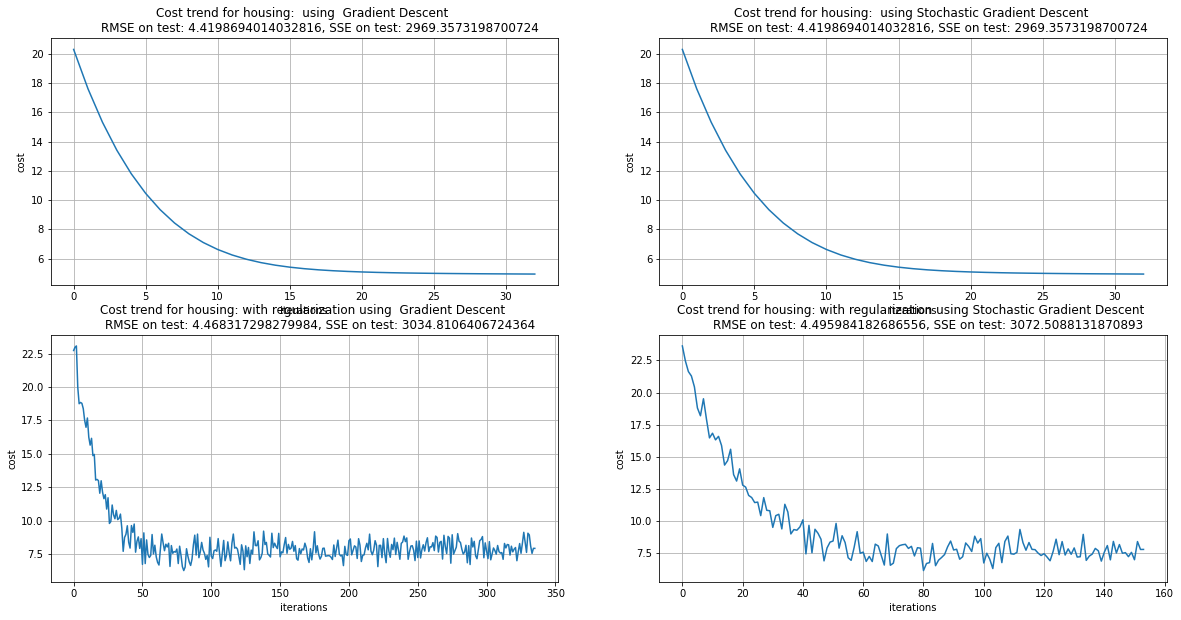

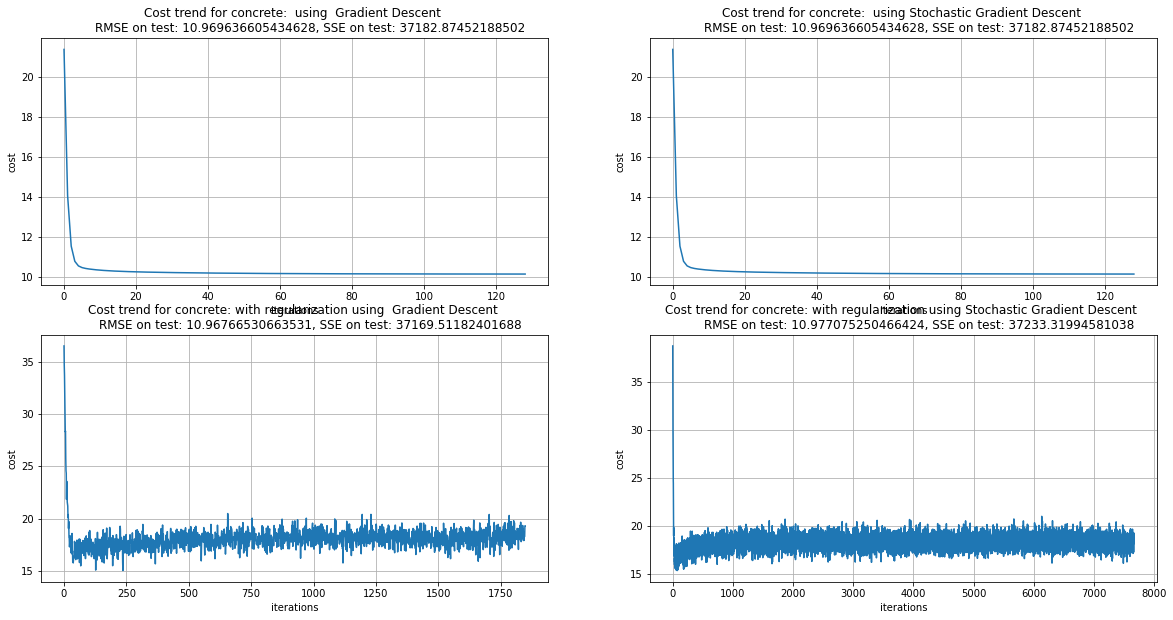

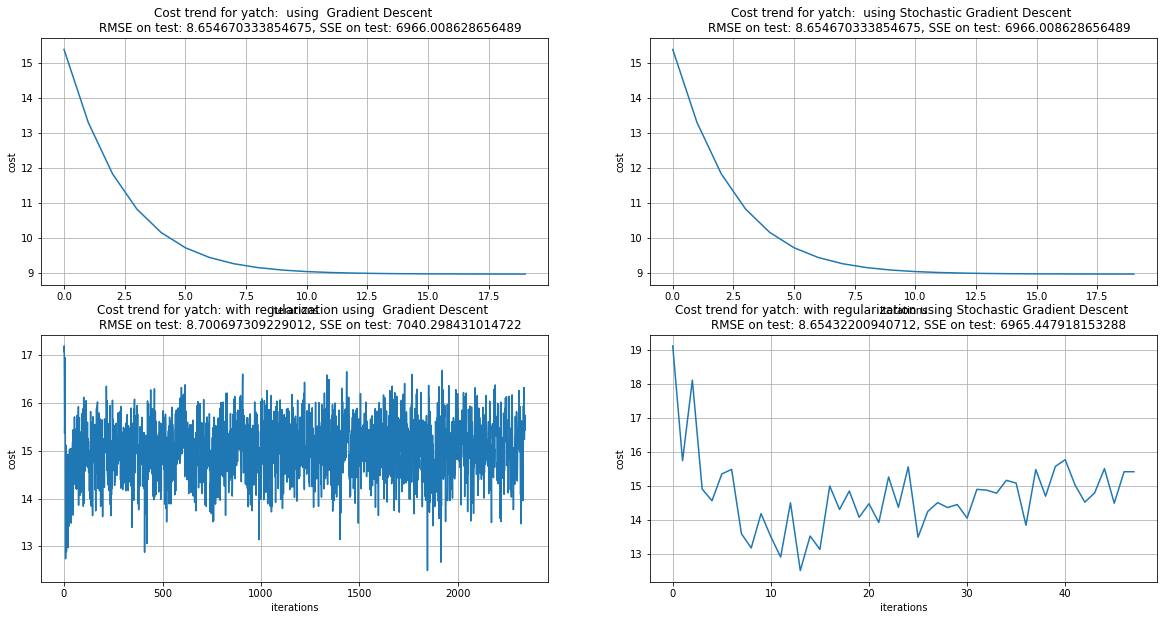

In [7]:
datasets = [
    {
        'name': 'housing',
        'kwargs': {
            'X': housing_df.values[:, 0:-1],
            'y': housing_df.values[:, -1],
            'learningRate': 0.0004,
            'tolerance': 0.005,
            'maxIteration': 50000,
            'gd': True,
            'stochastic': True,
            'reg': True,
            'batch_size': 100,
            'alpha': 1.0
        }
    },
    {
        'name': 'concrete',
        'kwargs': {
            'X': concrete_df.values[:, 0:-1],
            'y': concrete_df.values[:, -1],
            'learningRate': 0.0007,
            'tolerance': 0.0001,
            'maxIteration': 50000,
            'gd': True,
            'stochastic': True,
            'reg': True,
            'batch_size': 100,
            'alpha': 1.0
        }
    },
    {
        'name': 'yatch',
        'kwargs': {
            'X': yatch_df.values[:, 0:-1],
            'y': yatch_df.values[:, -1],
            'learningRate': 0.001,
            'tolerance': 0.001,
            'maxIteration': 50000,
            'gd': True,
            'stochastic': True,
            'reg': True,
            'batch_size': 100,
            'alpha': 1.0
        }
    }
]

for d in datasets:
    print(f"Running Model on dataset: {d['name']}")
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    for i in [0,1]:
      for j in [0,1]:
        d['kwargs']['reg'] = True if i==1 else False
        d['kwargs']['stochastic'] = True if i==1 else False
        model = LinearRegression(**d['kwargs'])
        model.fit()
        result, rmse_test, sse_test = model.predict_test()
        axs[i, j].plot(model.errors)
        axs[i, j].set_title(f"""Cost trend for {d['name']}: {'with regularization' if i==1 else ''} using {'Stochastic' if j==1 else ''} Gradient Descent 
        RMSE on test: {rmse_test}, SSE on test: {sse_test}""")
        
        print(rmse_test, sse_test)

    for ax in axs.flat:
        ax.grid()
        ax.set(xlabel='iterations', ylabel='cost')
        


# Observations

 **1. Stochastic model helps reach minimum values fast because of using only subset of data drawn randomly for training.**

 **2. Adding regularization helps skip local minimums by adding a small bias and in turn reduces variance to a considerable amount**
 
 **3. Increase in the learning rate makes the model to reach the minimum faster while making it close to 1 makes the model to bounce back without touching the global minima.**

 **4. Tolerance is used to not run the model once we got acceptable error difference or there is nothing more to learn**

 **5. MaxIterations is to avoid run model forever.**